In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
df = pd.read_excel('/content/cleaned_imputed_data.xlsx')

df.head()
print(df.columns)

feature_columns = [
    'Carbon content (wt%)',
    'Hydrogen content (wt%)',
    'Nitrogen content (wt%)',
    'Oxygen content (wt%)',
    'Sulfur content (wt%)',
    'Volatile matter (wt%)',
    'Fixed carbon (wt%)',
    'Ash content (wt%)',
    'Reaction temperature (°C)',
    'Microwave power (W)',
    'Reaction time (min)',
    'Microwave absorber percentage (%)',
    'Dielectric constant of absorber (ε′)',
    'Dielectric loss factor of absorber (ε“)'
]
target_columns = ['Bio-oil yield (%)',
       'Syngas yield (%)', 'Syngas composition (H₂, mol%)',
       'Syngas composition (CH₄, mol%)', 'Syngas composition (CO₂, mol%)',
       'Syngas composition (CO, mol%)', 'Biochar yield (%)',
       'Biochar calorific value (MJ/kg)', 'Biochar H/C ratio (-)',
       'Biochar H/N ratio (-)', 'Biochar O/C ratio (-)']

Index(['Reference (DOI)', 'Biomass type', 'Carbon content (wt%)',
       'Hydrogen content (wt%)', 'Nitrogen content (wt%)',
       'Oxygen content (wt%)', 'Sulfur content (wt%)', 'Volatile matter (wt%)',
       'Fixed carbon (wt%)', 'Ash content (wt%)', 'Reaction temperature (°C)',
       'Microwave power (W)', 'Reaction time (min)',
       'Microwave absorber percentage (%)',
       'Dielectric constant of absorber (ε′)',
       'Dielectric loss factor of absorber (ε“)', 'Bio-oil yield (%)',
       'Syngas yield (%)', 'Syngas composition (H₂, mol%)',
       'Syngas composition (CH₄, mol%)', 'Syngas composition (CO₂, mol%)',
       'Syngas composition (CO, mol%)', 'Biochar yield (%)',
       'Biochar calorific value (MJ/kg)', 'Biochar H/C ratio (-)',
       'Biochar H/N ratio (-)', 'Biochar O/C ratio (-)'],
      dtype='object')


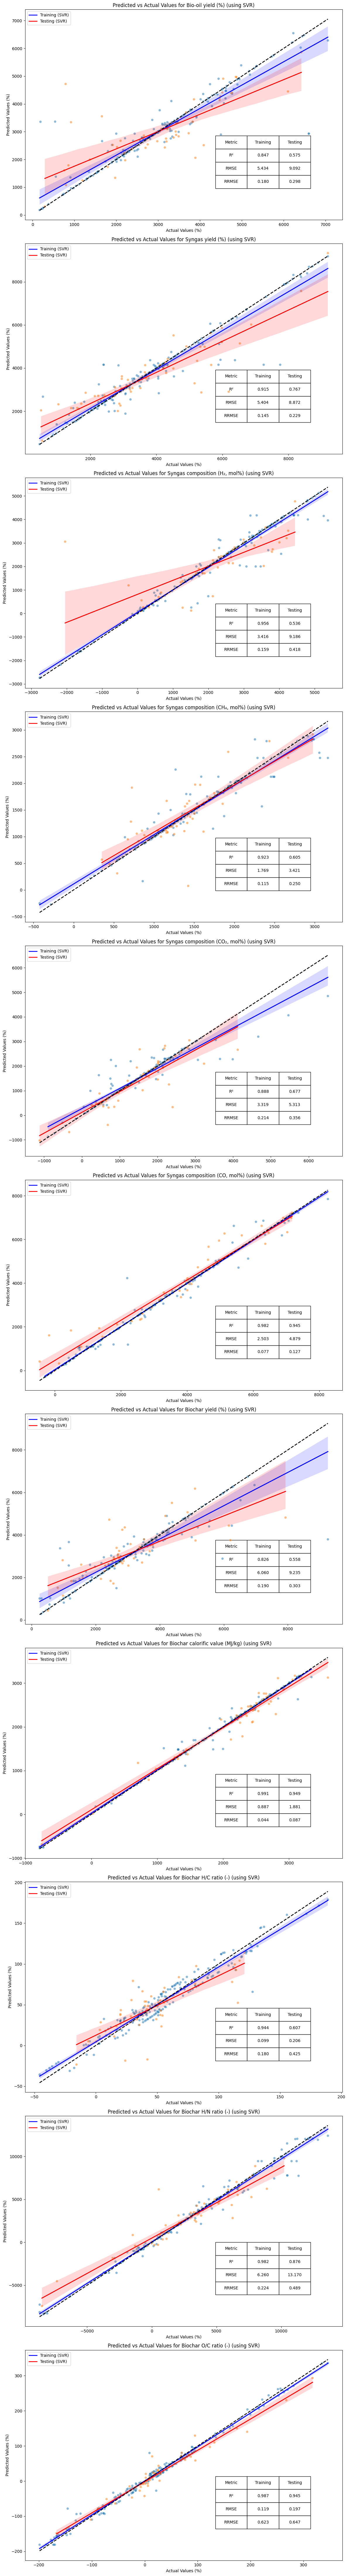

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

def plot_predicted_vs_actual_multi(df, feature_columns, target_columns, output_file=None):
    num_cols = len(target_columns)
    fig, axs = plt.subplots(num_cols, 1, figsize=(12, 8*num_cols))

    for idx, target_column in enumerate(target_columns):
        # Assign the feature columns to X and the target column to y
        X = df[feature_columns].values
        y = df[target_column].values

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Create and train the SVR model
        svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
        svr.fit(X_train, y_train)

        # Make predictions
        y_train_pred = svr.predict(X_train)
        y_test_pred = svr.predict(X_test)

        # Calculate R²
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Calculate RMSE
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Calculate RRMSE
        rrmse_train = rmse_train / np.mean(y_train)
        rrmse_test = rmse_test / np.mean(y_test)

        # Convert actual and predicted values to percentages for plotting
        y_train_percentage = y_train * 100
        y_train_pred_percentage = y_train_pred * 100
        y_test_percentage = y_test * 100
        y_test_pred_percentage = y_test_pred * 100

        # Combine data into a DataFrame for plotting with seaborn
        df_plot = pd.DataFrame({
            'Actual': np.concatenate((y_train_percentage, y_test_percentage)),
            'Predicted': np.concatenate((y_train_pred_percentage, y_test_pred_percentage)),
            'Dataset': ['Training'] * len(y_train_percentage) + ['Testing'] * len(y_test_percentage)
        })

        # Plot on the respective subplot
        ax = axs[idx]
        sns.scatterplot(data=df_plot, x='Actual', y='Predicted', hue='Dataset', alpha=0.5, ax=ax)

        # Training data trend line and confidence interval
        sns.regplot(data=df_plot[df_plot['Dataset'] == 'Training'], x='Actual', y='Predicted', scatter=False, color='blue', ax=ax)

        # Testing data trend line and confidence interval
        sns.regplot(data=df_plot[df_plot['Dataset'] == 'Testing'], x='Actual', y='Predicted', scatter=False, color='red', ax=ax)

        # Add diagonal line
        ax.plot([min(y) * 100, max(y) * 100], [min(y) * 100, max(y) * 100], 'k--', lw=2)

        # Add labels and title with target column
        ax.set_xlabel('Actual Values (%)')
        ax.set_ylabel('Predicted Values (%)')
        ax.set_title(f'Predicted vs Actual Values for {target_column} (using SVR)')

        # Create custom legend with both training and testing labels
        custom_lines = [plt.Line2D([0], [0], color='blue', lw=2),
                        plt.Line2D([0], [0], color='red', lw=2)]
        ax.legend(custom_lines, ['Training (SVR)', 'Testing (SVR)'], loc='upper left')

        # Add table with performance metrics
        table_data = [['R²', f'{r2_train:.3f}', f'{r2_test:.3f}'],
                      ['RMSE', f'{rmse_train:.3f}', f'{rmse_test:.3f}'],
                      ['RRMSE', f'{rrmse_train:.3f}', f'{rrmse_test:.3f}']]
        table = ax.table(cellText=table_data,
                         colLabels=['Metric', 'Training', 'Testing'],
                         cellLoc='center',
                         loc='bottom right',  # Adjusted to bottom right
                         bbox=[0.6, 0.15, 0.3, 0.25])  # Adjust bbox to control position and size

        # Adjust table font size and style
        table.auto_set_font_size(False)
        table.set_fontsize(10)

    plt.tight_layout()

    # Save the figure to a file if output_file is provided
    if output_file:
        plt.savefig(output_file)

    plt.show()

# Example usage:
# Assuming `df`, `feature_columns`, and `target_columns` are defined appropriately
# Also assuming `output_file` is the file path where you want to save the plot
feature_columns = [
    'Carbon content (wt%)',
    'Hydrogen content (wt%)',
    'Nitrogen content (wt%)',
    'Oxygen content (wt%)',
    'Sulfur content (wt%)',
    'Volatile matter (wt%)',
    'Fixed carbon (wt%)',
    'Ash content (wt%)',
    'Reaction temperature (°C)',
    'Microwave power (W)',
    'Reaction time (min)',
    'Microwave absorber percentage (%)',
    'Dielectric constant of absorber (ε′)',
    'Dielectric loss factor of absorber (ε“)'
]

target_columns = [
    'Bio-oil yield (%)',
    'Syngas yield (%)',
    'Syngas composition (H₂, mol%)',
    'Syngas composition (CH₄, mol%)',
    'Syngas composition (CO₂, mol%)',
    'Syngas composition (CO, mol%)',
    'Biochar yield (%)',
    'Biochar calorific value (MJ/kg)',
    'Biochar H/C ratio (-)',
    'Biochar H/N ratio (-)',
    'Biochar O/C ratio (-)'
]

output_file = 'SVR_predicted_vs_actual_multi.png'
plot_predicted_vs_actual_multi(df, feature_columns, target_columns, output_file)
